# SARIMAX

In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Data exploration

In [9]:
from electricity_price_predictor.data_2 import get_price, get_shifted_price
from electricity_price_predictor.data import fetch_data

In [14]:
df = get_price()

In [15]:
df_shifted = get_shifted_price()

In [17]:
df_shifted.shape

(51720, 1)

In [13]:
df.head(40)

,price
time,
2015-01-01 00:00:00,25.02
2015-01-01 01:00:00,18.29
2015-01-01 02:00:00,16.04
2015-01-01 03:00:00,14.60
2015-01-01 04:00:00,14.95
2015-01-01 05:00:00,14.50
2015-01-01 06:00:00,10.76
2015-01-01 07:00:00,12.01
2015-01-01 08:00:00,12.39


In [13]:
df_daily_chike = df_c.resample('D').mean()

DataError: No numeric types to aggregate

In [19]:
df_g.head(40)

,price
time,
2015-01-01 00:00:00,25.02
2015-01-01 01:00:00,18.29
2015-01-01 02:00:00,16.04
2015-01-01 03:00:00,14.60
2015-01-01 04:00:00,14.95
2015-01-01 05:00:00,14.50
2015-01-01 06:00:00,10.76
2015-01-01 07:00:00,12.01
2015-01-01 08:00:00,12.39


In [16]:
df_g=df_g.set_index('time')
df_daily = df_g.resample('D').mean()

In [18]:
df_daily.head(40)

,price
time,
2015-01-01,16.310417
2015-01-02,27.751250
2015-01-03,13.172500
2015-01-04,18.358750
2015-01-05,24.621250
2015-01-06,20.788750
2015-01-07,23.430417
2015-01-08,14.012917
2015-01-09,27.334167


In [81]:
df_test_mean.isnull().sum()

price    0
dtype: int64

In [82]:
df_test_mean

,price
time,
2015-01-01,26.90
2015-01-02,29.67
2015-01-03,25.69
2015-01-04,27.00
2015-01-05,25.69
...,...
2015-12-27,15.92
2015-12-28,24.21
2015-12-29,16.52


### Decomposition

- components:
 - Trend
 - Seaonal
 - cyclical 

- choose:
 - additive or multiplicative decomposition?   plot the residuls of both models and decide  

- statsmodel.tsa [Deterministic Processes](https://www.statsmodels.org/stable/tsa.html#)      

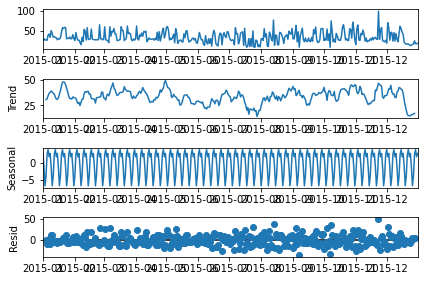

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df_test_mean, model='additive')
plt.figsize=(20,16)
result_add.plot();

In [7]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df, model='multiplicative', period=24*365)
result_mul.plot();

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

### Explore stationarity

Text(0.5, 1.0, 'First order diff of seasonal differencing 52')

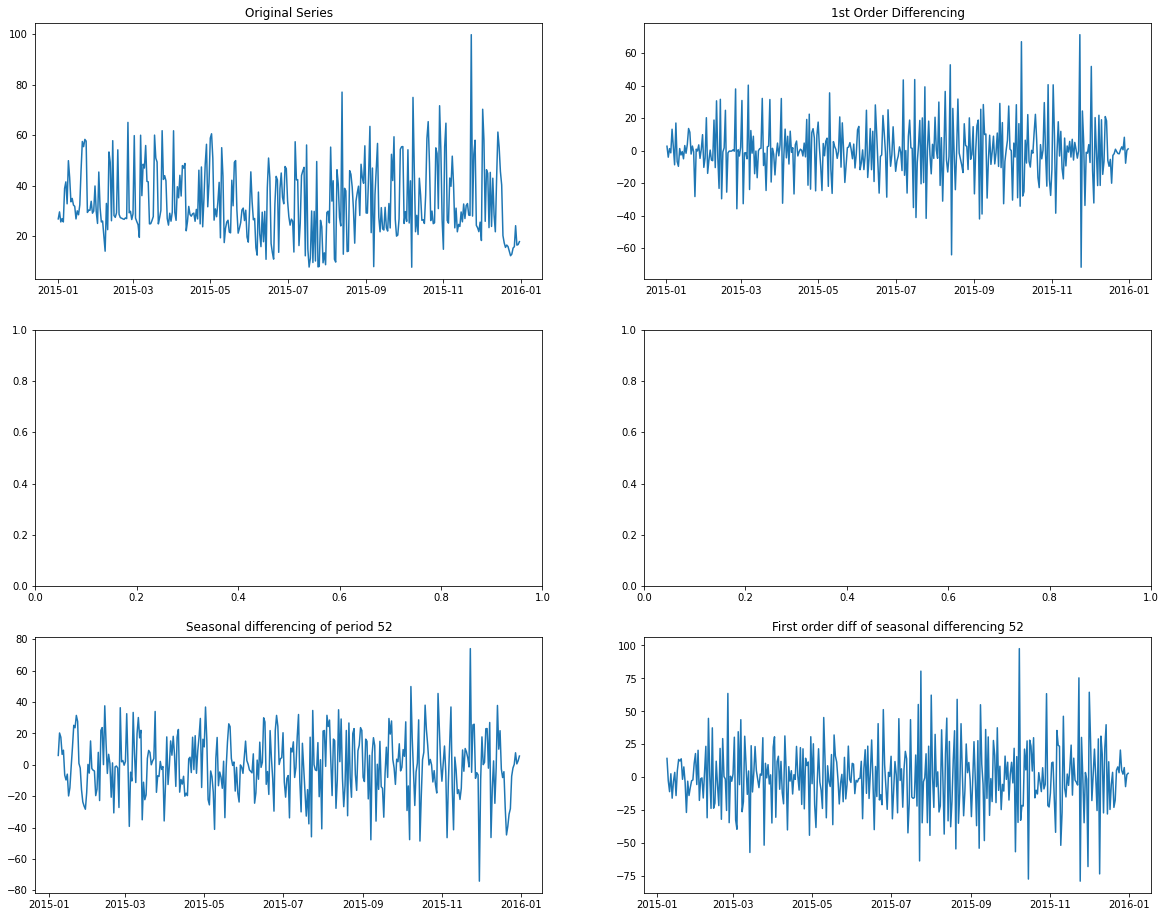

In [76]:
fig, axs = plt.subplots(3, 2, figsize=(20,16))
# Original series
axs[0,0].plot(df_test); axs[0,0].set_title('Original Series')

# Normal differencing
axs[0,1].plot(df_test.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[2,0].plot(df_test.diff(7))
axs[2,0].set_title('Seasonal differencing of period 52')

# Week + Normal differencing
axs[2,1].plot(df_test.diff(7).diff(1))
axs[2,1].set_title('First order diff of seasonal differencing 52')

In [36]:
# ADF test on lag day
day_ADF = adfuller(df, maxlag=24)
print(pd.Series(week_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -6.492946e+00
p-value           1.213874e-08
#Lags             6.000000e+00
Observations      2.148000e+03
dtype: float64


In [33]:
# ADF test on lag day
day_ADF = adfuller(df_1, maxlag=1)
print(pd.Series(week_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -6.492946e+00
p-value           1.213874e-08
#Lags             6.000000e+00
Observations      2.148000e+03
dtype: float64


In [77]:
# ADF test on lag week
week_ADF = adfuller(df_test)
print(pd.Series(week_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -1.531624e+01
p-value           4.122091e-28
#Lags             0.000000e+00
Observations      3.640000e+02
dtype: float64


In [35]:
# ADF test on lag month
month_ADF = adfuller(df_1, maxlag=365)
print(pd.Series(month_ADF[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic      -2.598516
p-value              0.093304
#Lags               50.000000
Observations      2104.000000
dtype: float64


### Autocorrelation

In [ ]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df.value, lags=50, ax=axes[0]);
plot_pacf(df.value, lags=50, ax=axes[1], color='r')

## hyperparameters

In [ ]:
# grid search the hyper params
import pmdarima as pm
smodel = pm.auto_arima(train, seasonal=True, m=7, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1, # check the params max_...
                       start_P=0, max_P=2, D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True) # The lower AIC the better

## SARIMAX Model

In [ ]:
# Create a correct Training/Test split to predict the last 50 points
train = df.linearized[0:150]
test = df.linearized[150:]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(engod=df['electricity_price'],
                 exog=df['day_of_week'],
                 order=(3, 0, 0),seasonal_order=(0,1,2,12)
                )
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05) # 95% confidence
forecast = results.predicted_mean
confidence_int = results.conf_int()

## Recomposition

In [ ]:
# re-compose back to initial time series

forecast_recons = np.exp(forecast)*result_mul.seasonal[150:]
train_recons = np.exp(train)*result_mul.seasonal[0:150]
test_recons = np.exp(test)*result_mul.seasonal[150:]
lower_recons = np.exp(confidence_int)[:,0]*result_mul.seasonal[150:]
upper_recons = np.exp(confidence_int)[:,1]*result_mul.seasonal[150:]

# plt 
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

## Inference validity

In [ ]:
## plot residuals to see whether their normal distributed
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Prophet

[reference for model_b](https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1)